# Kono - Github repo health data analyses

## Overview

My initial project at Red Hat was to pursue a means for assessing the health of a github project. It was envisaged that if project health metrics were established, these could enable determining insights not readily apparent by github's extant visualizations and features (e.g. repo graphs, pulse)  As a nascent member of the Emerging technology group at Red Hat, it was paramount my initial work also provide a means for getting familiar with, and learning the benefits of the tooling within our group as pertains to big data products. During the project's inception, this primarily was within the [Radanalytics](http://radanalytics.io) body of work which provides integration advantages of both [OpenShift](https://www.openshift.com/) for containerization of applications and Spark for scalable computation. With this in mind, in this article, I shall describe my journey with this project up to present.


## Related Work

While graduate school is blissfully far behind me, I would be remiss if I omitted details of what I consider a salient feature of any project undertaken: background checks. Call it a literature search, call it a prior art search, or call it creeping for info, it's a must to be certain one is not reinventing the wheel or stepping on anyone's legal toes. Particularly when embarking on a career with the world's leading open source company as in my case, there's no excuse for a lack of due diligence. Looking over the landscape of github repo data projects, the following stood out:

- [githut](http://githut.info/) is a project which gives a quarterly data on repository languages based on pushes. 

- [github-statistics](https://github.com/AndrewVos/github-statistics) pursued relationships between profanity in commit messages and project activity.

- [open source monthly](http://alysonla.github.io/open-source-monthly/) Tableau Public workbook connected to BigQuery. Shows type of events and activity per login.

- [octoboard](https://github.com/KuiKui/Octoboard) repo's referred URL is now a product site  for a BI dashboard. Uncertain if related, Octoboard was originally name of a github data challenge project. Shows timeline API activity.

- [GDC2](https://github.com/davidfischer/gdc2) geographic info for github repos. Pulls data files, massages, ranks by quanitity of repos in region.

- [Open Source Report Card](https://github.com/dfm/osrc) open source report card, uses deprecated API. Became Gild, which is now 404. 

This said to me that the work I had in mind was novel in that it could provide a means for insights not currently possible, along with the novelty of taking advantage of OpenShift and Spark.

## Data

In the same vein as checking out extant work, I next needed to understand what github repo data would be available. I prefer to see what I have to work with before embarking on feature engineering or otherwise. This again goes back to not reinventing the wheel, with the potential benefit of building off existing datasets and sources. 

### Sources

- github provides a [REST API](https://developer.github.com/v3/) for retrieving repo data. As one would expect, rate limitations are in place. The API permits checking for updates via a lightweight API call.

- [githubarchive](https://www.githubarchive.org) provides GZip compressed JSON files, each containing an hour of github event data.

- BigQuery provides a githubachive-based dataset [found here](https://cloud.google.com/bigquery/public-data/github). 

### Structure

- Events as defined in the [github event API docs](https://developer.github.com/v3/activity/events/types) are available using all aforementioned sources.

- Non-event data (e.g. repo, org, user details) is available from the github API, depending on privacy settings.


## Repo Health Metrics

Having an understanding of the data sources and availability, my next step was to consider what metrics would be appropriate in assessing the health of a project/repo, in data science-ish terms, this approaches feature engineering, but not quite. Put more simply, what makes a healthy repository? With this in mind, I assembled the following areas of interest with associated metrics I considered feasible:

- **Activity** - A healthy repository does not have tumbleweeds blowing through it. Even projects in maintenance will have just that, maintenance events. As such, a general sum of events broken down by type would be useful.

- **Interest** - A healthy repository inspires others to engage in what's provided. As such, data on number of the number of forks generated would be useful. As well as pull requests, issues, and comments. 

- **Responsiveness** - A good repository needs an owner/maintainer or group of such who, as needed, responds to communications from the community. Hence, another metric to consider is the response time in addressing pull requests and issues. 

- **Contributor Demeanor** - In my experience, the language one uses in their commit messages can be indicative of the contributor's mindset. For example, a disgruntled contributor might show up in [this project's](http://andrewvos.com/2011/02/21/amount-of-profanity-in-git-commit-messages-per-programming-language) radar. On the other end of the spectrum, commit messages with an excess of emoticons and effusiveness could betray a lack of seriousness about their craft. So sentiment analysis of commit messages in a repo could also be of value. As an aside, this metric resides in waters which can be tough to tread, since one might argue the commit language does not impact the efficacy of the contribution, however its exploring these fuzzy areas that are part of what makes what I do so much fun! 

- **Starring** - I am listing these as their own point, since the subjectiveness of starring is apparent. Standalone studies of correlations between starring and more quantitative metrics would be a subject unto themselves.


## Data Acquisition Approach

Given the metrics of interest, and what data sources are available, it was time to consider how I wanted to tackle this. First, this table indicates what I considered the advantages/disadvantages of the aforementioned sources:

| Source          | Advantage              | Disadvantage                                       |
| :-------------- | :--------------------- | :------------------------------------------------- |
| github API      | Direct from github     | Rate limited                                       |
| github archive  | No rate limit          | Requires initial download investment               |
| BigQuery        | Query driven interface | No 2017 data, analysis amount limited in free tier |

In my case, I wanted to be able to play with the data, making ~~some~~ many exploratory queries that lead to dead ends, back tracking as needed. As a result, the github API data and BigQuery usage limitations were not appealing. Since summary information is available in github's state of the Octoverse up to 2016 [articles](https://octoverse.github.com/) I chose to focus on data from Q1 2017. So, I began with this command to acquire the data files (note: this will download a large amount of data.)


In [15]:
! mkdir -p ./data/2017
! wget -q -N http://data.githubarchive.org/2017-{01..03}-{01..31}-{0..23}.json.gz -P ./data/2017
! echo "Download complete"

Download complete


## Preparing for Scalability

As mentioned, this is a large amount of data: hundreds of files for this quarter alone. I needed a means for processing this data in a parallel manner. Splitting each file into its own task seemed reasonable, since each record within the file has a timestamp. Looking further down the line, it seemed prudent (and useful for my project) if this work would be containerized as well. As a result, I pursued implementation in an OpenShift environment using a Docker image providing a means for utilizing pyspark-enabled Jupyter notebooks. This image was developed by members of the radanalytics community, at that. The instructions to get this up and running on one's local machine are fiendishly simple, and are as follows:

1. Download the oc command [here](https://github.com/openshift/origin/releases) and place somewhere within your path.

2. Install Docker Community Edition per [here](https://www.docker.com/community-edition).

3. Be sure to provide --insecure-registry 172.30.0.0/16 as an argument to the Docker daemon either via Docker's config files or the preferences panel within the docker toolbar entry.

3. From console, type oc cluster up. An OpenShift instance will be started on your local machine. 

4. You'll get a message with a url for connecting to the OpenShift web UI, browse to that using your browser of choice. For example, the following:

> The server is accessible via web console at:
>       https://127.0.0.1:8443

5. Your browser may complain about this connection being unsafe, make quick work of that and move on.

6. By default, an account with credentials developer/developer is created. Log in with these. 

7. By default, a project is created called MyProject, it will get the job done for most basic trying out needs. Click on it. 

8. Click add to project. 

9. Choose the Deploy Image tab. 

10. Select the Image Name radio button and type radanalyticsio/base-notebook, hit enter. 

11. To make life easier environment variables can be set for the Jupyter notebook settings, so that a password is used instead of a token. For example, JUPYTER_NOTEBOOK_PASSWORD can be set to NePtune.

12. Click create.

13. From the command line, type oc expose svc/base-notebook (Note: this can also be done via the web UI but I like the command line) 

14. Back to the web UI, there should be a URL for the route just exposed, this will lead to the PySpark Jupyter notebook goodness. 

15. Oho! It wants a password! Type in whatever was set previously for JUPYTER_NOTEBOOK_PASSWORD. Did you neglect to do this? Have no fear, there is another approach:

- Click on the 1 pod text with a circle around it, then click the terminal tab. 
- Following the instructions shown on the Jupyter URL you navigated to, type jupyter notebook list, copy what's output as the token, and paste into the password entry box of the Jupyter URL. 

16. Now for the real fun, upload your Jupyter notebook or start a new one and jam.

Having the base-notebook image in place is a huge convenience. However, it may not include some of the packages needed depending on application. As I learned, it's possible to install them locally within the cluster using Jupyter's bash magic commands as follows (Note: this could also be done via the terminal tab of the pod)

In [1]:
! pip install --user --quiet nltk
! pip install --user --quiet vaderSentiment

Of course, a Docker image could also be created that includes the necessary libraries, but this local method worked for me. Path of least resistance is my bff. 

So I started with some imports (I'm cheating and including everything I now know I need but these imports could be placed in as needed locations) and set up a SparkSession and context. Note the need to add the local packages, which live in site-packages, it's complicated, to the system path. Further note this image is Python 2.7 so prepare accordingly _vis a vis_ future print.

In [1]:
%matplotlib notebook
import re
import json
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import sys,os,os.path
import math
from matplotlib.ticker import MaxNLocator
from pyspark.sql import SparkSession
sys.path.append(os.path.expanduser('~/.local/lib/python2.7/site-packages'))
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

spark = SparkSession\
        .builder\
        .config("spark.executor.heartbeatInterval","3600s")\
        .appName("kono")\
        .getOrCreate()

sc = spark.sparkContext

### Activity via Number of Events

Finally, our first metric. For a given repo URL, I parsed the repo name, then start working through the data files to get all event instances. Due to differences in key names between event types, having only the name of the repo was insufficient, as a result, I call out to the github API just once to get the repo's internal ID which **is** universal across event records:

In [2]:
repoURL = 'https://github.com/radanalyticsio/oshinko-s2i'
repoFullName = repoURL.split('github.com/')[-1]

repoAPIURL = 'https://api.github.com/repos/' + repoFullName
repoID = requests.get(repoAPIURL).json()['id']

inFiles = "data/2017/2017*.json.gz"

eventRecords = sc.textFile(inFiles)\
            .map(lambda record: json.loads(record))\
            .filter(lambda record: record['repo']['id'] == repoID)\
            .cache()

er = eventRecords.collect()


Next I convert the event records to a Pandas dataframe, get the count of each record type, and massage the event type names to render a prettier bar plot in Seaborn.

<IPython.core.display.Javascript object>


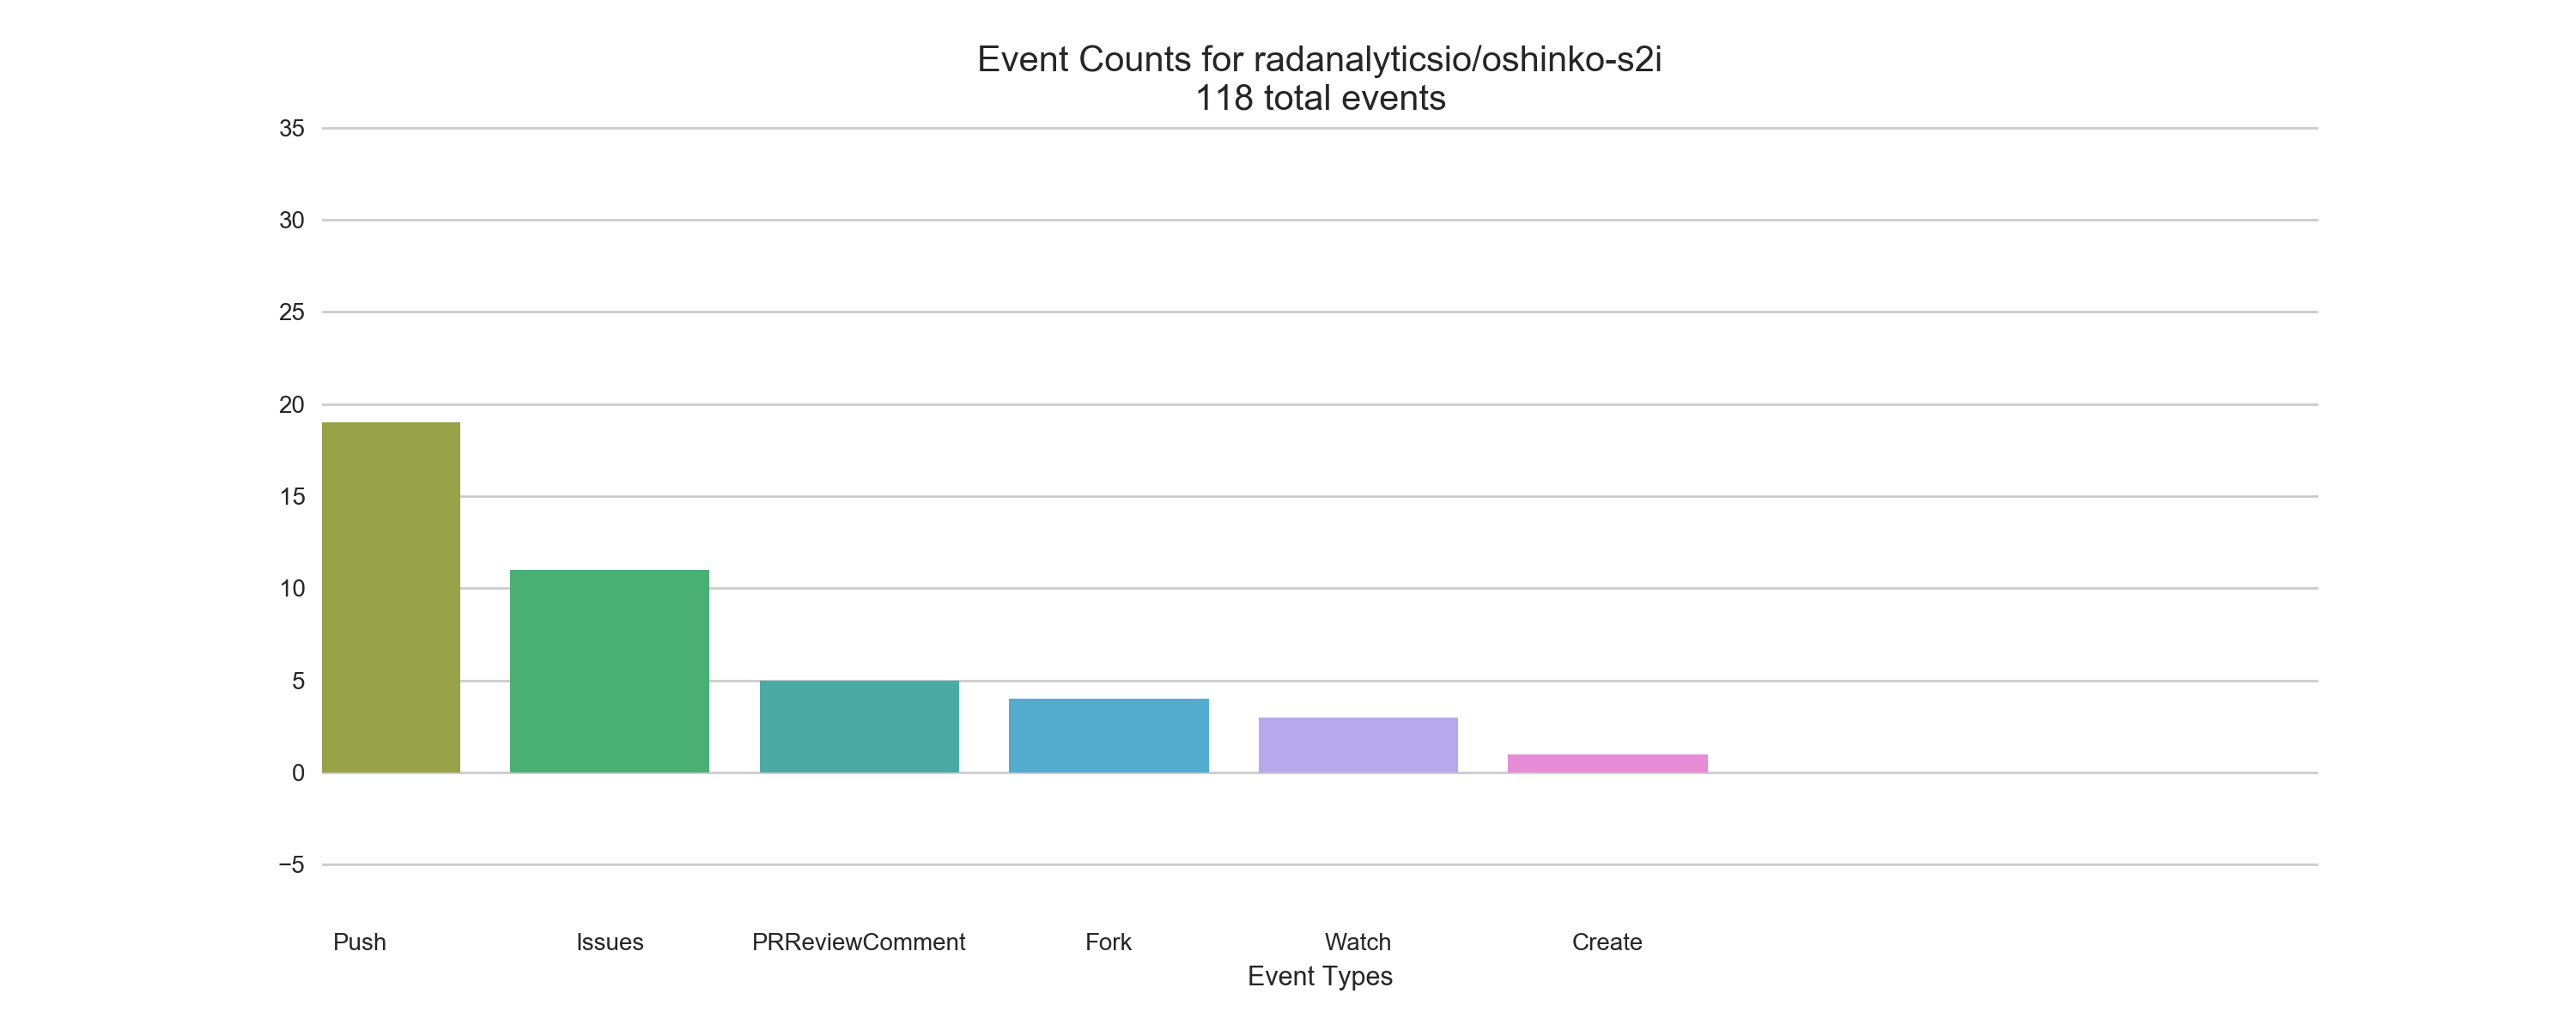

In [3]:
df = pd.read_json(json.dumps(er))
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(15, 6))
reduceddf = df['type'].map(lambda rec: re.sub(r'Event',r'',rec)).value_counts()
ticks = reduceddf.index.map(lambda index: re.sub(r'PullRequest',r'PR',index))
sns.barplot(y=reduceddf.values,x=ticks)
plt.title('Event Counts for ' + repoFullName +'\n'+str(len(df))+' total events',fontsize=15)
ax.set(ylabel="",
       xlabel="Event Types")
sns.despine(left=True, bottom=True)


### Responsivness
GitHub's record timestaps are in the format YYYY-mm-ddThh:mm:ssZ, the following gives a means for parsing timestamps and returning resolution time in days.
 

In [4]:
timeStampFormat = '%Y-%m-%dT%H:%M:%SZ'

def parseGitHubUTCTimeStamp(ts):
    return dt.datetime.strptime(ts, timeStampFormat)

def determineResolutionTime(opened,closed):
    td = closed - opened #rec[1][3]-rec[1][1]
    return td.days

#### Issue Resolution Time
For a given repo, I determined delta between issue posted and issue resolved.


In [5]:
def parseIssuesRecord(record):
    timeStamp = parseGitHubUTCTimeStamp(record['created_at'])
    issueID = record['payload']['issue']['id']
    action = record['payload']['action']
    return [issueID, [action, timeStamp]]

issuesRecords = eventRecords\
        .filter(lambda record: record['type'] == 'IssuesEvent')\
        .cache()

openedRecords = issuesRecords\
        .filter(lambda record: record['payload']['action'] == 'opened')\
        .count()
    
timesToCloseIssues = issuesRecords\
        .filter(lambda record: record['payload']['action'] == 'opened' or record['payload']['action'] == 'closed')\
        .map(lambda issuesRecord: parseIssuesRecord(issuesRecord))\
        .reduceByKey(lambda a,b: a+b)\
        .filter(lambda rec: len(rec[1])>2)\
        .map(lambda rec: determineResolutionTime(rec[1][1],rec[1][3]))\
        .collect()

And then I made another Seaborn plot, in this case I did a histogram of the number of days between issue creation and closing. 

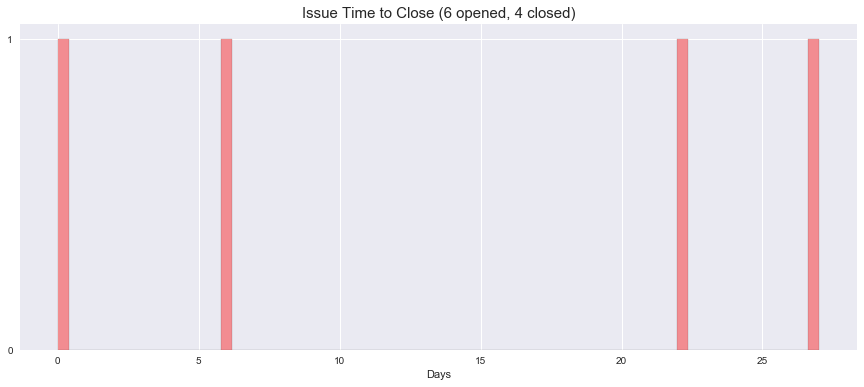

In [190]:
sns.set()
bx = plt.figure(figsize=(15, 6)).gca() 
import math
from matplotlib.ticker import MaxNLocator

sns.distplot(timesToCloseIssues,\
             kde=False,bins=70,color='red')
titleStr=('Issue Time to Close (' + str(openedRecords) + ' opened, ' + str(len(timesToCloseIssues)) + ' closed)')
bx.set(ylabel="",xlabel="Days")
plt.title(titleStr,fontsize=15)
bx.yaxis.set_major_locator(MaxNLocator(integer=True))


### Pull Request Close Time

For a given repo, I determined the delta between pull request opening and closing. 

In [191]:
def parsePullRequestRecord(record):
    timeStamp = parseGitHubUTCTimeStamp(record['created_at'])
    pullRequestID = record['payload']['pull_request']['id']
    action = record['payload']['action']
    merged = record['payload']['pull_request']['merged']
    return [pullRequestID, [action, timeStamp, merged]]

pullRequests = eventRecords\
        .filter(lambda record: record['type'] == 'PullRequestEvent')\
        .cache()

openedPullRequests = pullRequests\
        .filter(lambda record: record['payload']['action'] == 'opened')\
        .count()
    
    
timesToClosePulls = pullRequests\
        .filter(lambda record: record['payload']['action'] == 'opened' or record['payload']['action'] == 'closed')\
        .map(lambda record: parsePullRequestRecord(record))\
        .reduceByKey(lambda a,b: a+b)\
        .filter(lambda rec: len(rec[1])>3)\
        .map(lambda rec: determineResolutionTime(rec[1][1],rec[1][4]))\
        .collect()
        

I used Seaborn once again to create a histogram of the times. 

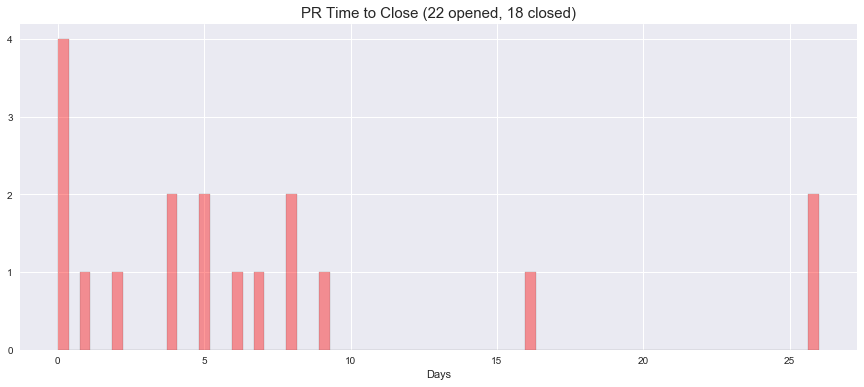

In [192]:
sns.set()
cx = plt.figure(figsize=(15, 6)).gca() 

sns.distplot(timesToClosePulls,\
             kde=False,bins=70,color='red')
titleStr=('PR Time to Close (' + str(openedPullRequests) + ' opened, ' + str(len(timesToClosePulls)) + ' closed)')
cx.set(ylabel="",xlabel="Days")
plt.title(titleStr,fontsize=15)
cx.yaxis.set_major_locator(MaxNLocator(integer=True))


### Sentiments

After some digging around for extant libraries, I determined I would get sentiment intensity values using the [Vader Sentiment](https://github.com/cjhutto/vaderSentiment) package. For an input string, values ranging from 0-1 are output for positive, neutral, and negative sentiments, as well as a composite sentiment based on the three intensities. Per vader's docs, I created an instance of the sentiment analyzer to be used throughout my sentiment metrics

In [193]:
analyzer = SentimentIntensityAnalyzer()

#### Commit Messages

For each commit message, vader determined their intensity triplet, from which I then took the mean of all three valences. Based on the percentage of each valence, I made a pie chart, using just Matplotlib in this case since Seaborn does not abide pie charts.

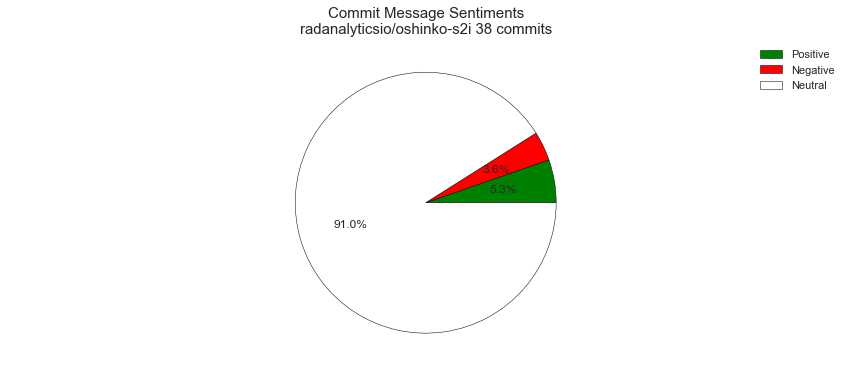

In [199]:
pushPayloads=df[df['type']=='PushEvent']['payload']

neg=0
pos=0
neu=0
numCommits = 0

for p in pushPayloads.keys():
    for cm in pushPayloads[p]['commits']:
        numCommits+=1
        scores=analyzer.polarity_scores(cm['message'])
        neg+=scores['neg']
        pos+=scores['pos']
        neu+=scores['neu']
if(numCommits > 0):
    neg/=numCommits
    pos/=numCommits
    neu/=numCommits
    x_list = [pos,neg,neu]
    label_list = ['+','-','n']
    sns.set_style("whitegrid")
    p1x = plt.figure(figsize=(15, 6)).gca() 
    p1x.axis("equal") 
    p1x.pie(x_list,autopct="%1.1f%%",colors=['green','red','white'])
    plt.rcParams['patch.linewidth'] = 0.5
    plt.rcParams['patch.force_edgecolor'] = True
    plt.title("Commit Message Sentiments\n"+repoFullName+' '+str(numCommits)+' commits',fontsize=15)
    p1x.legend(['Positive','Negative','Neutral'],fontsize=11)
else:
    print("No commit messages")
    
        

#### Issue Comments

For each issue comment, I again checked the sentiment and made a pie chart as per the commit messages.

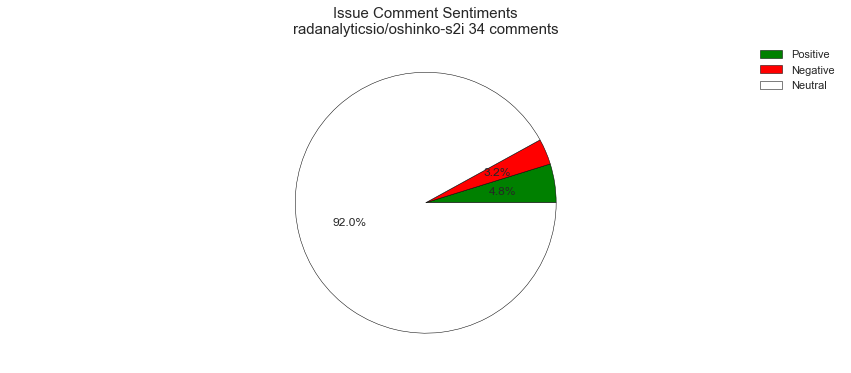

In [200]:
issuePayloads=df[df['type']=='IssueCommentEvent']['payload']

neg=0
pos=0
neu=0
numIssueComments = 0

for p in issuePayloads.keys():
    numIssueComments+=1
    scores=analyzer.polarity_scores(issuePayloads[p]['comment']['body'])
    neg+=scores['neg']
    pos+=scores['pos']
    neu+=scores['neu']

if(numIssueComments > 0):
    neg/=numIssueComments
    pos/=numIssueComments
    neu/=numIssueComments
    x_list = [pos,neg,neu]
    sns.set_style("whitegrid")
    p2x = plt.figure(figsize=(15, 6)).gca() 
    p2x.axis("equal") 
    plt.rcParams['patch.linewidth'] = 0.5
    plt.rcParams['patch.force_edgecolor'] = True
    p2x.pie(x_list,autopct="%1.1f%%",colors=['green','red','white']) 
    plt.title("Issue Comment Sentiments\n"+repoFullName+' '+str(numIssueComments)+' comments',fontsize=15)
    p2x.legend(['Positive','Negative','Neutral'],fontsize=11)
else:
    print("No issue comments")

#### Pull Request Review Comments

For each pull request review comment, I checked the sentiment and made a pie chart as per the commit messages.

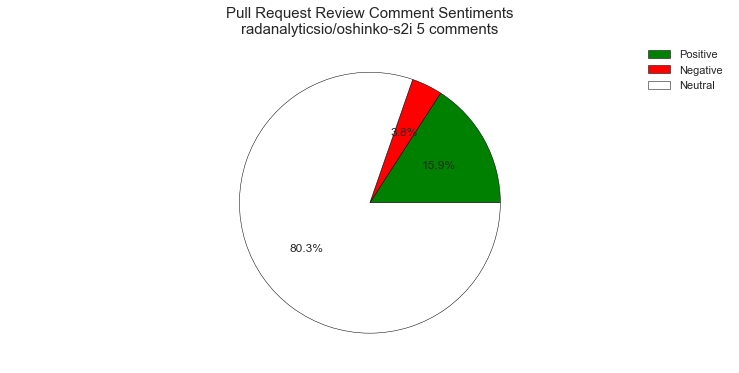

In [202]:
pullRequestReviewPayloads=df[df['type']=='PullRequestReviewCommentEvent']['payload']

neg=0
pos=0
neu=0
numPullRequestReviewComments = 0

for p in pullRequestReviewPayloads.keys():
    numPullRequestReviewComments+=1
    scores=analyzer.polarity_scores(pullRequestReviewPayloads[p]['comment']['body'])
    neg+=scores['neg']
    pos+=scores['pos']
    neu+=scores['neu']
    
if(numPullRequestReviewComments > 0):
    neg/=numPullRequestReviewComments
    pos/=numPullRequestReviewComments
    neu/=numPullRequestReviewComments
    x_list = [pos,neg,neu]
    p3x = plt.figure(figsize=(13, 6)).gca() 
    p3x.axis("equal") 
    plt.rcParams['patch.linewidth'] = 0.5
    plt.rcParams['patch.force_edgecolor'] = True
    p3x.pie(x_list,autopct="%1.1f%%",colors=['green','red','white']) 
    plt.title("Pull Request Review Comment Sentiments\n"+repoFullName+' '+str(numPullRequestReviewComments)+' comments',fontsize=15)
    p3x.legend(['Positive','Negative','Neutral'],fontsize=11)
else:
    print("No pull request review comments")


## Lessons Learned

In each case, OpenShift with the base-notebook image made life much easier. The implicit 